# CIFAR10 classification using Haiku

[Haiku](https://dm-haiku.readthedocs.io/en/latest/) is a library built on top of JAX designed to provide simple, composable abstractions for machine learning research.

GitHub repo: https://github.com/deepmind/dm-haiku

## Configuration

Imports

In [1]:
import math
from collections import namedtuple, defaultdict
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import haiku as hk
import optax

import tensorflow as tf
import tensorflow_datasets as tfds

Disable GPU usage by TensorFlow:

In [2]:
tf.config.set_visible_devices([], 'GPU')

In [3]:
jax.local_devices()

[GpuDevice(id=0, process_index=0)]

Configuration

In [4]:
IMAGE_SIZE = 32

NUM_CLASSES = 10
BATCH_SIZE = 32
EPOCHS = 100

LEARNING_RATE = 1e-2
WEIGHT_DECAY = 1e-2

## Data

In [5]:
def augment_image(img):
    img = tf.image.resize_with_crop_or_pad(img, 40, 40)
    img = tf.image.random_crop(img, [32, 32, 3])
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    img = tf.image.random_saturation(img, 0.8, 1.2)
    return img

In [6]:
def train_process_sample(x):
    image = augment_image(x['image'])
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return {'images': image, 'labels': x['label']}

In [7]:
def val_process_sample(x):
    image = tf.image.convert_image_dtype(x['image'], dtype=tf.float32)
    return {'images': image, 'labels': x['label']}

In [8]:
def prepare_train_dataset(dataset_builder, batch_size):
    ds = dataset_builder.as_dataset(split='train')
    ds = ds.repeat()
    ds = ds.map(train_process_sample, num_parallel_calls=tf.data.AUTOTUNE)
    df = ds.shuffle(16 * batch_size, reshuffle_each_iteration=True, seed=0)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    ds = tfds.as_numpy(ds)
    return ds

In [9]:
def prepare_val_dataset(dataset_builder, batch_size):
    ds = dataset_builder.as_dataset(split='test')
    ds = ds.map(val_process_sample, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(tf.data.AUTOTUNE)
    ds = tfds.as_numpy(ds)
    return ds

In [10]:
dataset_builder = tfds.builder('cifar10')

In [11]:
dataset_builder.download_and_prepare()

In [12]:
train_steps_per_epoch = math.ceil(dataset_builder.info.splits['train'].num_examples / BATCH_SIZE)
val_steps_per_epoch = math.ceil(dataset_builder.info.splits['test'].num_examples / BATCH_SIZE)

In [13]:
train_ds = prepare_train_dataset(dataset_builder, BATCH_SIZE)
val_ds = prepare_val_dataset(dataset_builder, BATCH_SIZE)

In [14]:
train_iter = iter(train_ds)
val_iter = iter(val_ds)

## Model

Utilities

In [15]:
class Sequential(hk.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = tuple(layers)
    
    def __call__(self, inputs, *args):
        out = inputs
        for layer in self.layers:
            out = layer(out, *args)
        return out

In [16]:
class ConvBlock(hk.Module):
    def __init__(self, channels, kernel_size, stride = 1, act = True):
        super().__init__()
        self.act = act
        self.conv = hk.Conv2D(channels, kernel_size, stride=stride, with_bias=False, padding="SAME",
                              w_init=hk.initializers.VarianceScaling(2., "fan_in", "truncated_normal"))
        self.bn = hk.BatchNorm(create_scale=True, create_offset=True, decay_rate=0.9)
    
    def __call__(self, inputs, is_training):
        out = self.conv(inputs)
        out = self.bn(out, is_training)
        if self.act:
            out = jax.nn.swish(out)
        return out

Residual blocks

In [17]:
class ResidualBlock(hk.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.residual_blocks = Sequential([ConvBlock(channels, 3),
                                           ConvBlock(channels, 3, act=False)])
    
    def __call__(self, inputs, is_training):
        shortcut = inputs
        residual = self.residual_blocks(inputs, is_training)
        
        if shortcut.shape != residual.shape:
            shortcut = ConvBlock(self.channels, 1, act=False)(shortcut, is_training)
        
        gamma = hk.get_parameter("gamma", [], inputs.dtype, init=jnp.zeros)
        out = shortcut + gamma * residual
        out = jax.nn.swish(out)
        return out

In [18]:
class Stage(hk.Module):
    def __init__(self, channels, num_blocks, stride):
        super().__init__()
        self.stride = stride
        if stride > 1:
            self.pool = hk.MaxPool(stride, strides=stride, padding="VALID")
        self.blocks = Sequential([ResidualBlock(channels) for _ in range(num_blocks)])
    
    def __call__(self, inputs, is_training):
        out = inputs
        if self.stride > 1:
            out = self.pool(out)
        out = self.blocks(out, is_training)
        return out

In [19]:
class Body(hk.Module):
    def __init__(self, channel_list, num_blocks_list, strides):
        super().__init__()
        self.stages = Sequential([Stage(channels, num_blocks, stride)
                                  for channels, num_blocks, stride in zip(channel_list, num_blocks_list, strides)])
    
    def __call__(self, inputs, is_training):
        out = self.stages(inputs, is_training)
        return out

ResNet

In [20]:
class Stem(hk.Module):
    def __init__(self, channel_list, stride):
        super().__init__()
        blocks = []
        for channels in channel_list:
            blocks.append(ConvBlock(channels, 3, stride=stride))
            stride = 1
        self.blocks = Sequential(blocks)
    
    def __call__(self, inputs, is_training):
        out = self.blocks(inputs, is_training)
        return out

In [21]:
class Head(hk.Module):
    def __init__(self, classes, p_drop=0.):
        super().__init__()
        self.p_drop = p_drop
        self.linear = hk.Linear(classes)
    
    def __call__(self, inputs, is_training):
        out = jnp.mean(inputs, axis=(1, 2))
        if is_training and self.p_drop > 0:
            out = hk.dropout(hk.next_rng_key(), self.p_drop, out)
        out = self.linear(out)
        return out

In [22]:
class ResNet(hk.Module):
    def __init__(self, classes, channel_list, num_blocks_list, strides, head_p_drop = 0.):
        super().__init__()
        self.stem = Stem([32, 32, 64], strides[0])
        self.body = Body(channel_list, num_blocks_list, strides[1:])
        self.head = Head(classes, head_p_drop)
    
    def __call__(self, inputs, is_training):
        out = self.stem(inputs, is_training)
        out = self.body(out, is_training)
        out = self.head(out, is_training)
        return out

### Model initialization

In [23]:
def _forward(batch, is_training):
    images = batch['images']
    model = ResNet(NUM_CLASSES,
                   channel_list = [64, 128, 256, 512],
                   num_blocks_list = [2, 2, 2, 2],
                   strides = [1, 1, 2, 2, 2],
                   head_p_drop = 0.3)
    return model(images, is_training)

In [24]:
forward = hk.transform_with_state(_forward)

In [25]:
rng = jax.random.PRNGKey(0)

In [26]:
init_rng, rng = jax.random.split(rng)

In [27]:
batch = next(train_iter)

In [28]:
params, state = forward.init(init_rng, batch, is_training=True)

### Model summary

In [29]:
def summary_fn(params, state, rng, batch):
    logits, new_state = forward.apply(params, state, rng, batch, is_training=True)
    return logits

In [30]:
def format_module_name(name):
    parts = name.split('~')
    return "  " * (len(parts) - 1) + parts[-1]

In [31]:
tabulate_fn = hk.experimental.eval_summary(summary_fn)

In [32]:
summary = tabulate_fn(params, state, rng, batch)

In [33]:
print("{:32} | {:17} | {:17} | {}".format("Module","Input","Output", "Param count"))
print("=" * 86)
for i in summary:
    print("{:32} | {:17} | {:17} | {:,}".format(
        format_module_name(i.module_details.module.module_name),
        str(i.args_spec[0]),
        str(i.output_spec),
        hk.data_structures.tree_size(i.module_details.params)))

Module                           | Input             | Output            | Param count
res_net                          | f32[32,32,32,3]   | f32[32,10]        | 11,200,882
  /stem                          | f32[32,32,32,3]   | f32[32,32,32,64]  | 28,768
    /sequential                  | f32[32,32,32,3]   | f32[32,32,32,64]  | 28,768
    /conv_block                  | f32[32,32,32,3]   | f32[32,32,32,32]  | 928
      /conv2_d                   | f32[32,32,32,3]   | f32[32,32,32,32]  | 864
      /batch_norm                | f32[32,32,32,32]  | f32[32,32,32,32]  | 64
        /mean_ema                | f32[1,1,1,32]     | f32[1,1,1,32]     | 0
        /var_ema                 | f32[1,1,1,32]     | f32[1,1,1,32]     | 0
    /conv_block_1                | f32[32,32,32,32]  | f32[32,32,32,32]  | 9,280
      /conv2_d                   | f32[32,32,32,32]  | f32[32,32,32,32]  | 9,216
      /batch_norm                | f32[32,32,32,32]  | f32[32,32,32,32]  | 64
        /mean_ema                

## Training

### Loss

In [34]:
def cross_entropy_loss(logits, labels):
    one_hot_labels = jax.nn.one_hot(labels, NUM_CLASSES)
    loss = optax.softmax_cross_entropy(logits=logits, labels=one_hot_labels).mean()
    return loss

In [35]:
@jax.jit
def loss_fn(params, state, rng, batch):
    logits, new_state = forward.apply(params, state, rng, batch, is_training=True)
    loss = cross_entropy_loss(logits, batch['labels'])
    return loss, (new_state, logits)

In [36]:
grad_fn = jax.grad(loss_fn, has_aux=True)

### Metrics

In [37]:
def compute_metrics(logits, labels):
    loss = cross_entropy_loss(logits, labels)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    metrics = {
      'loss': loss,
      'accuracy': accuracy,
    }
    return metrics

### Optimizer

In [38]:
num_train_steps = train_steps_per_epoch * EPOCHS

In [39]:
shedule_fn = optax.cosine_onecycle_schedule(transition_steps=num_train_steps, peak_value=LEARNING_RATE)

In [40]:
optim = optax.adamw(learning_rate=shedule_fn, weight_decay=WEIGHT_DECAY)

In [41]:
opt_state = optim.init(params)

### Train State

In [42]:
TrainState = namedtuple("TrainState", ["params", "state", "opt_state", "rng"])

In [43]:
train_state = TrainState(params, state, opt_state, rng)

### Train functions

In [44]:
@jax.jit
def train_step(train_state, batch):
    rng, new_rng = jax.random.split(train_state.rng)
    grads, (new_state, logits) = grad_fn(train_state.params, train_state.state, rng, batch)
    
    updates, new_opt_state = optim.update(grads, train_state.opt_state, train_state.params)
    new_params = optax.apply_updates(train_state.params, updates)
    
    train_state = TrainState(new_params, new_state, new_opt_state, new_rng)
    
    metrics = compute_metrics(logits, batch['labels'])
    return train_state, metrics

In [45]:
@jax.jit
def eval_step(train_state, batch):
    logits, _ = forward.apply(train_state.params, train_state.state, None, batch, is_training=False)
    metrics = compute_metrics(logits, batch['labels'])
    return metrics

In [46]:
def metrics_summary(metrics):
    metrics = jax.device_get(metrics)
    metrics = jax.tree_multimap(lambda *args: np.stack(args), *metrics)
    summary = jax.tree_map(lambda x: x.mean(), metrics)
    return summary

In [47]:
def log_metrics(history, summary, name):
    print(f"{name}: ", end='', flush=True)
    for key, val in summary.items():
        history[name + ' ' + key].append(val)
        print(f"{key} {val:.3f} ", end='')

In [48]:
def train(train_state, train_iter, val_iter, epochs):
    history = defaultdict(list)
    
    for epoch in range(1, epochs + 1):
        print(f"{epoch}/{epochs} - ", end='')
        
        train_metrics = []
        for step in range(train_steps_per_epoch):
            batch = next(train_iter)
            train_state, metrics = train_step(train_state, batch)
            train_metrics.append(metrics)
        
        summary = metrics_summary(train_metrics)
        log_metrics(history, summary, 'train')
        print('; ', end='')
        
        val_metrics = []
        for step in range(val_steps_per_epoch):
            batch = next(val_iter)
            metrics = eval_step(train_state, batch)
            val_metrics.append(metrics)
        
        summary = metrics_summary(val_metrics)
        log_metrics(history, summary, 'val')
        print()
    
    return history

### Start training

In [49]:
history = train(train_state, train_iter, val_iter, EPOCHS)

1/100 - train: accuracy 0.510 loss 1.355 ; val: accuracy 0.669 loss 0.951 
2/100 - train: accuracy 0.711 loss 0.826 ; val: accuracy 0.753 loss 0.717 
3/100 - train: accuracy 0.769 loss 0.667 ; val: accuracy 0.768 loss 0.678 
4/100 - train: accuracy 0.802 loss 0.581 ; val: accuracy 0.781 loss 0.654 
5/100 - train: accuracy 0.817 loss 0.529 ; val: accuracy 0.817 loss 0.550 
6/100 - train: accuracy 0.830 loss 0.492 ; val: accuracy 0.802 loss 0.612 
7/100 - train: accuracy 0.841 loss 0.461 ; val: accuracy 0.833 loss 0.507 
8/100 - train: accuracy 0.850 loss 0.437 ; val: accuracy 0.833 loss 0.511 
9/100 - train: accuracy 0.857 loss 0.412 ; val: accuracy 0.847 loss 0.468 
10/100 - train: accuracy 0.864 loss 0.394 ; val: accuracy 0.854 loss 0.445 
11/100 - train: accuracy 0.872 loss 0.375 ; val: accuracy 0.846 loss 0.463 
12/100 - train: accuracy 0.876 loss 0.361 ; val: accuracy 0.847 loss 0.475 
13/100 - train: accuracy 0.879 loss 0.353 ; val: accuracy 0.847 loss 0.477 
14/100 - train: accur

In [50]:
def plot_history_train_val(history, key):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.arange(1, len(history['train ' + key]) + 1)
    ax.plot(xs, history['train ' + key], '.-', label='train')
    ax.plot(xs, history['val ' + key], '.-', label='val')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.legend()
    ax.grid()
    plt.show()

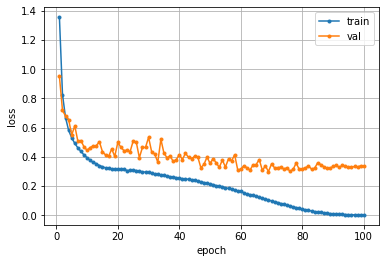

In [51]:
plot_history_train_val(history, 'loss')

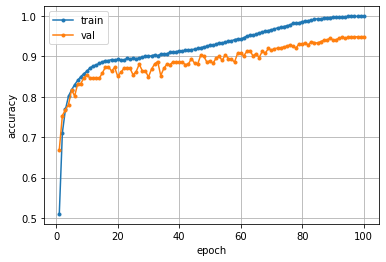

In [52]:
plot_history_train_val(history, 'accuracy')